In [1]:
import os

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from cdcm import *

# Single Zone RC Model system

Here we consider modeling a single zone RC system of a building in CDCM. In RC modeling, the heat transfer dynamics are modeled using thermal resistance (R) and capacitance (C). Here in single zone RC system, we have a clock system, weather system and an RC system which represents the grey box model of a single zone in a building. The weather system is ```DataSystem``` class object. ```DataSystem``` represents a system which can read through a data sequence.

In [2]:
with System(name="single_zone_rc") as single_zone_rc:
    
    # ****************************
    # System 0
    # ****************************
    clock = make_clock(1800)
    
    # ****************************
    # System 1
    # ****************************
    df = pd.read_csv("./rc_system_data/weather_data_2017_pandas.csv")
    weather_system = make_data_system(
        df[["Tout", "Qsg"]],
        name="weather_sytem",
        column_units=["degC", "W"],
        column_desciptions=[
            "Outdoor air temperature",
            "Solar irradiance"
        ]
    )
    
    # ****************************
    # System 2
    # ****************************
    
    with System(name="RC system") as rc_system:
        T_env = State(
            name="T_env",
            value=20.0,
            units="degC",
            track=True,
            description="Temperature of envelope inner surface"
        )

        T_room = State(
            name="T_room",
            value=23.0,
            units="degC",
            track=True,
            description="Temperature of room"
        )

        T_genv = State(
            name="T_genv",
            value=23.0,
            units="degC",
            track=True,
            description="Temperature of ground envelope inner surface"
        )

        C_env = Parameter(
            name="C_env",
            value=3.1996e6,
            units="J/C",
            description="Capacitance of the envelope"
        )

        C_room = Parameter(
            name="C_room",
            value=3.5187e5,
            units="J/C",
            description="Capacitance of the room air"
        )

        C_genv = Parameter(
            name="C_genv",
            value=np.inf,
            units="J/C",
            description="Capacitance of the room air"
        )

        R_rc = Parameter(
            name="R_rc",
            value=0.00706,
            units="C/W",
            description="Thermal resistance between room and corridor"
        )

        R_oe = Parameter(
            name="R_oe",
            value=0.02707,
            units="C/W",
            description="Thermal resistance between outdoor and envelope"
        )

        R_er = Parameter(
            name="R_er",
            value=0.00369,
            units="C/W",
            description="Thermal resistance between room and envelope"
        )

        R_gr = Parameter(
            name="R_gr",
            value=np.inf,
            units="C/W",
            description="Thermal resistance between room and ground envelope"
        )

        R_ge = Parameter(
            name="R_ge",
            value=0.00369,
            units="C/W",
            description="Thermal resistance between ground envelope and ground"
        )

        a_sol_env = Parameter(
            name="a_sol_env",
            value=0.90303,
            description="Absorptance of envelope with respect to solar gain"
        )

        a_sol_room = Parameter(
            name="a_sol_room",
            value=0.90303,
            description="Absorptance of room with respect to solar irradiance"
        )

        a_IHG = Parameter(
            name="a_IHG",
            value=0.90303,
            description="Absorptance of room with respect to internal heatgain"
        )

        T_gd = Variable(
            name="T_gd",
            value=18,
            units="degC",
            description="The temperature of ground. "
        )

        Q_int = Variable(
            name="Q_int",
            units="W",
            value=150,
            description="Sum of internal heat gain"
        )

        u_t = Variable(
            name="u_t",
            units="W",
            value=0.0,
            description="Input loads"
        )

        T_cor = Variable(
            name="T_cor",
            units="degC",
            value=23,
            description="Corridor temperature"
        )

        A = Variable(
            name="A",
            value=np.zeros((3, 3)),
            description="The matrix of the dynamical system (discretized)."
        )

        B = Variable(
            name="B",
            value=np.zeros((3, 6)),
            description="The B matrix (discretized)."
        )

        @make_function(A, B)
        def make_matrices(
            dt=clock.dt,
            R_oe=R_oe,
            R_er=R_er,
            R_rc=R_rc,
            R_gr=R_gr,
            R_ge=R_ge,
            C_room=C_room,
            C_env=C_env,
            C_genv=C_genv,
            a_sol_env=a_sol_env,
            a_sol_room=a_sol_room,
            a_IHG=a_IHG
        ):
            """Makes the dynamical system matrices and discretizes them"""
            cA = np.zeros((3, 3))
            cA[0, 0] = (-1. / C_env) * (1. / R_er + 1./R_oe)
            cA[0, 2] = 1. / (C_env * R_er)
            cA[1, 1] = (-1. / C_genv) * (1. / R_ge + 1. / R_gr)
            cA[1, 2] = 1. / (C_genv * R_gr)
            cA[2, 0] = 1. / (C_room * R_er)
            cA[2, 1] = 1. / (C_room * R_gr)
            cA[2, 2] = (-1. / C_room) * (1. / R_er + 1. / R_gr + 1. / R_rc)

            cB = np.zeros((3, 6))
            cB[0, 1] = 1./(C_env * R_oe)
            cB[0, 2] = a_sol_env / C_env
            cB[0, 3] = (1 - a_IHG) / C_env
            cB[1, 1] = 1. / (C_genv * R_ge)
            cB[2, 2] = a_sol_room / C_room
            cB[2, 3] = a_IHG / C_room
            cB[2, 4] = 1. / (C_room * R_rc)
            cB[2, 5] = 1. / C_room

            cC = np.array([[0, 0, 1]])
            cD = np.zeros(6)

            tmp = signal.StateSpace(cA, cB, cC, cD)
            discrete_matrix = tmp.to_discrete(dt=dt)
            A = discrete_matrix.A
            B = discrete_matrix.B

            return A, B

        @make_function(T_env, T_genv, T_room)
        def transition_room(
            T_env=T_env,
            T_room=T_room,
            T_genv=T_genv,
            T_cor=T_cor,
            T_gd=T_gd,
            u=u_t,
            dt=clock.dt,
            A=A,
            B=B,
            # add noise for Tout, Qsg and Q_int
            T_out=weather_system.Tout,
            Q_sg=weather_system.Qsg,
            Q_int=Q_int
        ):
            """Transitions the system."""
            # print("Actual shape of A:", np.shape(A))
            res = (
                A @ np.array([T_env, T_genv, T_room]).T
                + B @ np.array([T_out, T_gd, Q_sg, Q_int, T_cor, u]).T
                # + B @ np.append([T_out, T_gd, Q_sg, Q_int, T_cor], u)
            )
            return res[0], res[1], res[2]

        T_room_sensor = Variable(
            name="T_room_sensor",
            units="degC",
            value=23.0,
            description="A temperature sensor at the room"
        )

        T_room_sensor_sigma = Parameter(
            name="T_room_sensor_sigma",
            units="degC",
            value=0.01,
            description="Standard deviation of the measurement noise"
        )

        @make_function(T_room_sensor)
        def g_T_room_sensor(
            T_room=T_room,
            T_room_sensor_sigma=T_room_sensor_sigma
        ):
            """Get a sensor measurement."""
            return T_room + T_room_sensor_sigma * np.random.randn()

print(single_zone_rc)

['Tout' 'Qsg'] ['degC', 'W'] ['Outdoor air temperature', 'Solar irradiance'] (True, True)
single_zone_rc:
  description: ''
  owner: ''
  nodes:
    dt:
      description: The timestep.
      owner: single_zone_rc/clock
      parents: ()
      children: ('tick', 'single_zone_rc/RC system/make_matrices', 'single_zone_rc/RC
        system/transition_room')
      value: 1800
      units: seconds
      track: true
    t:
      description: The time.
      owner: single_zone_rc/clock
      parents: ('tick',)
      children: ('tick',)
      value: 0.0
      units: seconds
      track: true
    tick:
      description: Moves time forward by `dt`.
      owner: single_zone_rc/clock
      parents: ('t', 'dt')
      children: ('t',)
      func: &id001 !!python/name:cdcm.clock.tick ''
    clock:
      description: A system that counts time.
      owner: single_zone_rc
      nodes:
        dt:
          description: The timestep.
          owner: single_zone_rc/clock
          parents: ()
         

## Simulation and saving results

As we have created the single zone RC system, we can now a CDCM SimulationSaver object called ```saver``` which will save the simulation results when simulation is run to the file with name ```single_zone_rc.h5```. We run the simulation by calling the forward() and tranistion() functions of the ```single_zone_rc``` inside a for loop till the maximum step is reached.

The Simulation saver assumes that the file with given file name does not exist when a file name is passed as argument. Due to this reason, the file is removed before creating Simulation saver object if it exists already.

In [3]:
max_steps = 500
file_name = "single_zone_rc.h5"

if os.path.exists(file_name):
        os.remove(file_name)

saver = SimulationSaver(file_name,
                        single_zone_rc,
                        max_steps=max_steps
)
for i in range(max_steps):
    single_zone_rc.forward()
    saver.save()
    single_zone_rc.transition()

## Fetching and ploting the results

Here we fetch the quantity of interest by quering the path of the quantity in the simulation saver object. By giving the path ```"/single_zone_rc/RC system/T_room_sensor"``` to the file_handler of the simulation saver object, we get a numpy array ```T_room_sensor_arr``` consisting the simulation results of ```T_room_sensor```. We can easily plot and visualize the result after fetching it.

In [4]:
T_room_sensor_arr = (
    saver.file_handler[
        "/single_zone_rc/RC system/T_room_sensor"
    ][:]
)

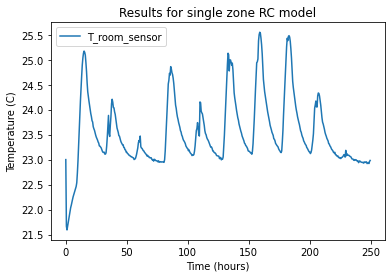

In [5]:
time = np.arange(max_steps) * 0.5
plt.plot(time, T_room_sensor_arr, label='T_room_sensor')
plt.ylabel('Temperature (C)')
plt.xlabel('Time (hours)')
plt.title('Results for single zone RC model')
plt.legend()
plt.show()